<a href="https://colab.research.google.com/github/adampotton/Cognitive_AI_CW/blob/main/Q2D.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Imports

In [28]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Define Model

In [70]:
img_size_div4 = 32 # Image size

class AttentionLayer(nn.Module):
    def __init__(self, in_channels):
        super(AttentionLayer, self).__init__()
        self.conv = nn.Conv2d(in_channels, 1, kernel_size=1)  # Generates a single channel score map

    def forward(self, x):
        attention_weights = torch.sigmoid(self.conv(x))  # Sigmoid to get values in range [0, 1]
        return attention_weights, x * attention_weights

class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=8, kernel_size=3, padding=1)  # First convolutional layer
        self.conv2 = nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3, padding=1)  # Second convolutional layer
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)  # Max pooling layer
        self.dropout = nn.Dropout(p=0.5)  # Dropout layer with 50% probability of dropping units
        self.fc1 = nn.Linear(16 * img_size_div4 * img_size_div4, 128)  # Reduced from 256 to 128
        self.fc2 = nn.Linear(128, 3)  # Output layer for 3 classes (nike, adidas, converse)
        self.attn1 = AttentionLayer(8) # First attention layer
        self.attn2 = AttentionLayer(16) # Second attention layer

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x))) # First convolutional layer with ReLU and pooling
        attn1_weights, x = self.attn1(x) # First attention layer
        x = self.pool(torch.relu(self.conv2(x)))  # Second convolutional layer with ReLU and pooling
        attn2_weights, x = self.attn2(x)  # Second attention layer
        x = self.dropout(x)  # Apply dropout
        x = x.view(-1, 16 * img_size_div4 * img_size_div4)  # Flatten the output for the fully connected layer
        x = torch.relu(self.fc1(x))  # Fully connected layer with ReLU
        x = self.dropout(x) # Apply dropout to the fully connected layer output
        x = self.fc2(x)  # Output layer
        return x, attn1_weights, attn2_weights

### Load and Edit Data

In [68]:
img_size = img_size_div4 * 4

transform = transforms.Compose([ # Define training augmentation and tarnsformations
    transforms.Resize((img_size, img_size)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Define paths to your train and test directories
train_dir = '/content/drive/MyDrive/Cognitive_AI/shoes/train'
test_dir = '/content/drive/MyDrive/Cognitive_AI/shoes/test'

batch_size = 8
train_dataset = datasets.ImageFolder(root=train_dir, transform=transform) # Load datasets using ImageFolder
test_dataset = datasets.ImageFolder(root=test_dir, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True) # Create DataLoader for batching
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

### Train the Model

In [69]:
lr = 0.001
wd = 1e-4
num_epochs = 10

model = CNN()

criterion = nn.CrossEntropyLoss()  # Loss function and optimizer
optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=wd)

for epoch in range(num_epochs):
    model.train()  # Set model to training mode
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in train_loader: # Loop through images and labels to train
        optimizer.zero_grad()
        output,_,_ = model(images)

        loss = criterion(output, labels)
        running_loss += loss.item()

        loss.backward()
        optimizer.step()

        _, predicted = torch.max(output, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    epoch_loss = running_loss / len(train_loader)
    epoch_accuracy = correct / total
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.4f}")


Epoch 1/10, Loss: 1.1042, Accuracy: 0.3474
Epoch 2/10, Loss: 1.0614, Accuracy: 0.4444
Epoch 3/10, Loss: 0.9598, Accuracy: 0.5513
Epoch 4/10, Loss: 0.8146, Accuracy: 0.6512
Epoch 5/10, Loss: 0.6533, Accuracy: 0.7440
Epoch 6/10, Loss: 0.5321, Accuracy: 0.7834


KeyboardInterrupt: 

In [47]:
model.eval()  # Set model to evaluation mode
correct = 0
total = 0

with torch.no_grad():  # No need to track gradients during evaluation
    for images, labels in test_loader:
        output = model(images)
        _, predicted = torch.max(output, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

test_accuracy = correct / total
print(f"Test Accuracy: {test_accuracy:.4f}")

Test Accuracy: 0.5877


### Sample Code for Visualising an Image

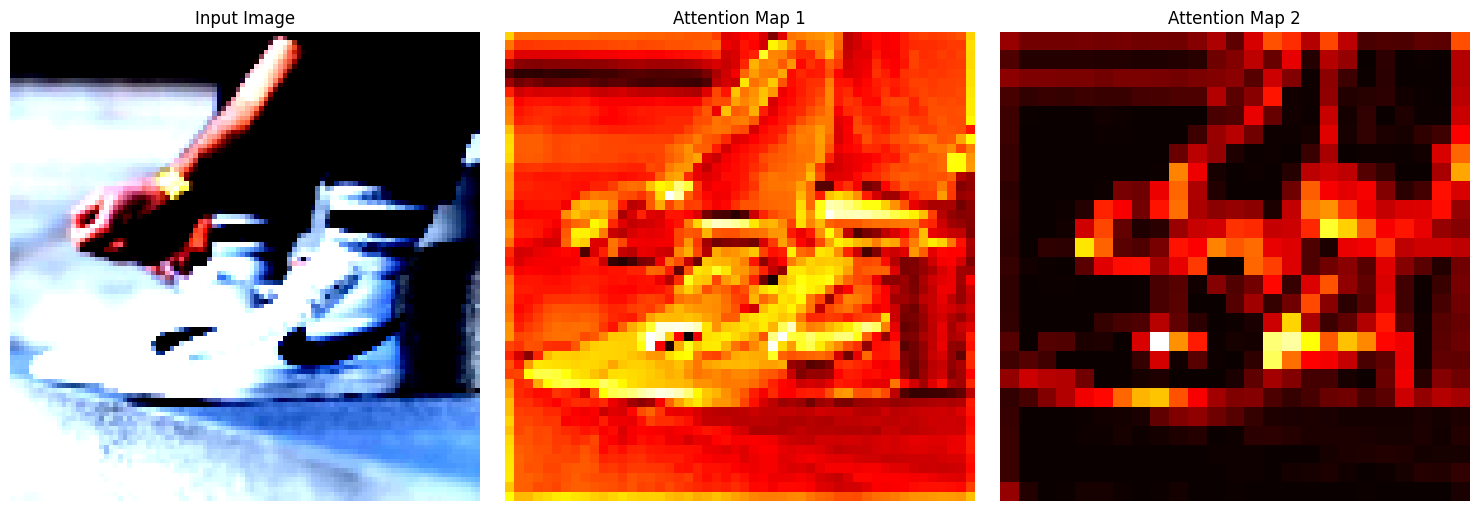

In [64]:
def visualize_attention(model, image, class_names):
    # Ensure the image has the right shape (e.g., 3x100x100)
    image = image.unsqueeze(0)  # Add batch dimension if needed (batch size of 1)

    # Forward pass through the model
    output, attn1_weights, attn2_weights = model(image)

    # Convert the attention weights to the same shape as the feature map
    # Assuming attn1_weights and attn2_weights are of shape (batch_size, channels, H, W)
    attn1_map = attn1_weights.squeeze().cpu().detach().numpy()  # Remove batch dim and convert to NumPy
    attn2_map = attn2_weights.squeeze().cpu().detach().numpy()

    # Normalize the attention maps to [0, 1] for visualization
    attn1_map = (attn1_map - attn1_map.min()) / (attn1_map.max() - attn1_map.min())
    attn2_map = (attn2_map - attn2_map.min()) / (attn2_map.max() - attn2_map.min())

    # Visualize the attention maps
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))


    image_np = image.squeeze().permute(1, 2, 0).cpu().detach().numpy() # Plot the original image
    axes[0].imshow(image_np)
    axes[0].set_title('Input Image')
    axes[0].axis('off')

    axes[1].imshow(attn1_map, cmap='hot') # Plot attention map 1
    axes[1].set_title('Attention Map 1')
    axes[1].axis('off')

    axes[2].imshow(attn2_map, cmap='hot') # Plot attention map 2
    axes[2].set_title('Attention Map 2')
    axes[2].axis('off')

    plt.tight_layout()
    plt.show()


class_names = ["Nike", "Adidas", "Converse"]  # Update with your actual class names

# Get an image from the DataLoader (for example, the first image in the batch)
image, label = next(iter(train_loader))

# Visualize the attention maps for this image
visualize_attention(model, image[0], class_names)